# Prosper Loans 2005-2008 - Characteristics of Borrowers and Loan Success
## by Andy Watson

## Background of the Dataset

I investigated loans from Prosper Marketplace (the country's first peer-to-peer lending marketplace), looking for variables that could serve as good predictors of a loan's future success or failure. 

To keep the project manageable, I restricted the search for predictor variables to borrower characteristics (ex: borrower's income, but not the loan's interest rate).

To ensure that I was dealing only with loans that should've been successfully completed by 2014 (when they stopped updating our dataset), I restricted my examination to loans originating between 2005 and 2008 (the loans in that time frame were 1 or 3 year loans, so at the latest all should've been paid off by 2011, according to the original terms of the loans).

As it happens, the timeframe from 2005 through 2008 also overlaps with the time prior to the SEC's ruling against Prosper, the subsequent changes in Prosper's business practices and the concommittant reduction in defaulted loans. That is to say, from what I've gathered (https://en.wikipedia.org/wiki/Prosper_Marketplace), it seems that during the time period I that reviewed, a high percentage of Prosper loans defaulted. It should also be remembered that the Financial Crisis of 2007-2008 happened during the time under review.

From 2006 to 2009, Prosper allowed the borrowers and lenders to together set their own rates. After the SEC's intervention, Prosper began dictating the loan rates based on an algorithm.

The 2005 through 2008 timeframe I selected also largely coincided with the 2007-2008 global financial crisis.

From all this, we can see that the data under review turned out to be a pretty special case.



## Measuring the Success of the Loans

How to measure a loan's success? 

My first idea was to reorganize the LoanStatus variable from one that recorded whether or not a loan was completed, defaulted, called off, or cancelled to one that simply declared a loan Successful (if it was completed by 2014) or Unsuccessful (if it was defaulted or called of by 2014) (from 2005 through 2008, only 5 loans were cancelled and I left them out of the evaluation). I named this new variable NewLoanStatus.

I soon began to worry that the Successful/Unsuccesful (ie: completed or not completed) metric did not contain enough information. For example, both a loan that recovered of all the principal plus 90% of the interest and a loan that recovered \\$0 would be classified "Unsuccessful", even though the former loan was clearly much more successful than the latter.

So I then created another variable called ROI (for "return on investment") that was created by subtracting the total money Prosper had spent on the loan from the total money Prosper had made on the loan.

I compared these two metrics (favoring ROI, but also paying some attention to NewLoanStatus) against various possible predictor variables: StatedMonthlyIncome, IncomeRange, CreditGrade, CreditScoreRangeUpper, DebtToIncomeRatio, AmountDelinquent. These comparisons were made first on graphs and then mathematically, using correlation tests (Spearman and Pearson).

StatedMonthlyIncome (SMI for short) and IncomeRange are closely related, as were CreditScoreRangeUpper (CSRU for short) and CreditGrade. But SMI and CSRU are numeric values, while IR and CG are categorical variables. Numeric variables are easier to work with when doing correlation tests, so I focused more on SMI and CSRU. 

(Note that in the few trials I ran comparing both CreditScoreRangeLower and CreditScoreRangeUpper to predictor variables, I got identical correlation coefficients. This and the obvious close similarity between the two led me to conclude that for my purposes here, I could assume they were functionally equivalent. I chose CSRU over CSRL for no particular reason.)

I found that CSRU had the best correlation scores. These scores were higher with NewLoanStatus than with ROI, but I still preferred ROI, as it seemed the more meaningful metric.



## Focus of the Slideshow

This slideshow features graphs of the count distributions of my two metric variables, graphs of ROI versus the CSRU, and a summary of the correlation test results. 

I conclude the slideshow with a graph and correlation scores for the highest correlation scores I could find between ROI and StatedMonthlyIncome. To get these correlation scores, I had to manipulate the data in the following manner:

(1) Remove the SMIs that lay outside of the graph's primary shape. And then (2) split the data into Successful and Unsuccessful loans. 

I don't know how useful this final refinement is for predicting whether or not a loan will be successful. After all, you wouldn't know whether any given possible (but as yet nonexistent) loan should be put in the Successful or Unsuccessful data subsets. However, I became interested in discovering the largest possible correlation coefficients between ROI and SMI (without materially altering the data), and so I thought I'd share this finding. 

In general, the results from this investigation were pretty dissappointing. 

A weak correlation is generally considered to start at about correlation coefficient scores of |.1|. Of the possible predictors that I tested, only CreditScoreRangeUpper scored at or above |.1| when I ran the correlation tests with ROI. Perhaps this is due to the poor performance of Prosper loans during the studied interval. And/Or perhaps there is some flaw in my analysis. And/Or (given my lack of knowledge in this field I must still entertain the possibilty that) perhaps the correlations are just generally not that strong and loan success is generally difficult to predict.

It was reassuring that my two metrics correlated significantly with each other: the Spearman correlation score for ROI and NewLoanStatus was .72. 



## Dataset Overview

The file contains data on 113,937 loans (rows) with 81 variables (columns).

Variables include loan amount, interest rate, information about borrower's financial history, and current loan status.

The data was collected from 2005 through 2014.

After I removed all the loans that originated after the end of 2008, I was left with 29056 loans.



In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loan = pd.read_csv('prosperLoanData.csv')

In [3]:
# make a copy of the data frame
loans_to_2008 = loan.copy()

# change the ListingCreationDate variable to datetime format
loans_to_2008['ListingCreationDate'] = pd.to_datetime(loans_to_2008['ListingCreationDate']) 

In [4]:
# choose the loans made from 2005 through 2008
loans_to_2008 = (loans_to_2008[loans_to_2008['ListingCreationDate'].dt.year <= 2008])
# the dataframe needs a continuous index
loans_to_2008.reset_index(drop=True, inplace=True)

In [5]:
# creating successful and unsuccessful columns

# create a dictionary so you can map the values onto the new category names
dict_map = dict(zip(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'], ['Successful', 'Unsuccessful', 'Unsuccessful', 'Cancelled']))
# create a NewLoanStatus variable by mapping the dictionary onto the LoanStatus dictionary
loans_to_2008['NewLoanStatus'] = loans_to_2008['LoanStatus'].map(dict_map)

In [6]:
# creating the ROI variable by calculating the loans' return on investments
loans_to_2008['ROI'] = (loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 


In [7]:
# as an exercise, I'll turn these ordinal variables into categories computationally.

# convert CreditGrade and IncomeRange into ordered categorical types
ordinal_var_dict = {'CreditGrade': ['AA', 'A', 'B', 'C', 'D', 'E', 'HR','NC'],
                    'IncomeRange': ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+','Not employed', 'Not displayed']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    loans_to_2008[var] = loans_to_2008[var].astype(ordered_var)

In [8]:
# creating the typical_incomes dataframe and Successful & Unsuccessful subsets
# (for the final graph)

# create typical_incomes df
typical_incomes = (loans_to_2008[(loans_to_2008['StatedMonthlyIncome'] <= 60000) & (loans_to_2008['StatedMonthlyIncome'] >= 300)]).copy()
typical_incomes.reset_index(drop=True, inplace=True)

# create successful and unsuccessful dataframes
typ_succ = typical_incomes[typical_incomes['NewLoanStatus']=='Successful'].copy()
typ_unsucc = typical_incomes[typical_incomes['NewLoanStatus']=='Unsuccessful'].copy()

# the below are used to draw lines depicting each variable's mean value on the graph
avg_smi_succ = typ_succ.StatedMonthlyIncome.mean()
avg_roi_succ = typ_succ.ROI.mean()
avg_smi_unsu = typ_unsucc.StatedMonthlyIncome.mean()
avg_roi_unsu = typ_unsucc.ROI.mean()

## Distribution Counts for NewLoanStatus 

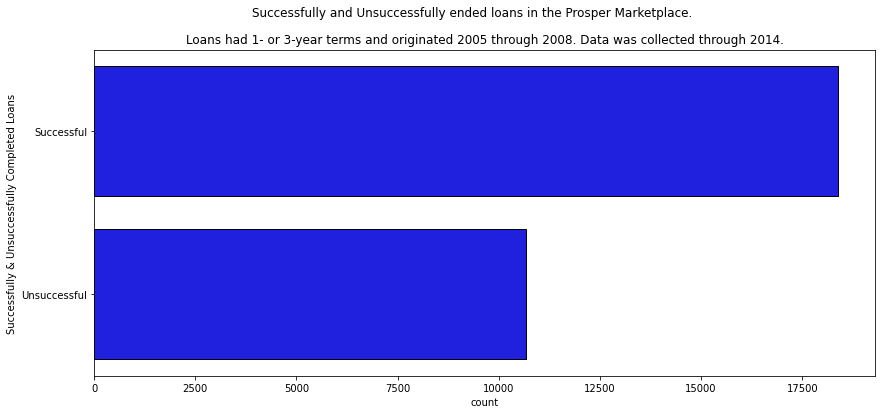

In [9]:
# countplot of successfully completed versus uncompleted loans
# remove the Cancelled loans (I am not sure if they count as Successful or Unsuccessful, and there are only 5 of them anyway)
no_cancelled = loans_to_2008[loans_to_2008['NewLoanStatus']!='Cancelled'].copy()
plt.figure(figsize=[14, 6])
sb.countplot(data=no_cancelled, y='NewLoanStatus', color='blue', edgecolor='black')
plt.suptitle('Successfully and Unsuccessfully ended loans in the Prosper Marketplace.')
plt.ylabel('Successfully & Unsuccessfully Completed Loans')
plt.title('Loans had 1- or 3-year terms and originated 2005 through 2008. Data was collected through 2014.');


> If we declare all loans that originated between 2005 and 2008 and that were completed by 2014 "Successful", and the rest of those loans (either Defaulted or Chargedoff, and ignoring the 5 Cancelled loans) "Unsuccessful, about 63% of the loans were successful.

## Distribution Counts for ROI

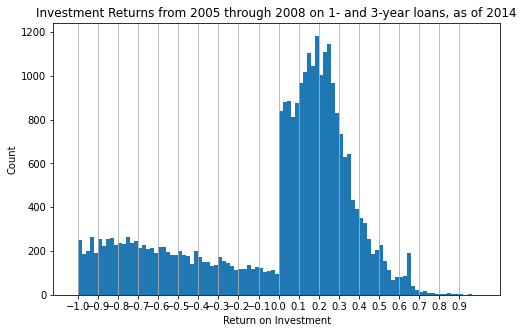

In [10]:
# histogram of ROI variable
binsize = .02
ticksize = .1
bins = np.arange(-1-binsize, 1+binsize, binsize)
ticks = np.arange(-1, 1, ticksize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'ROI', bins=bins)
plt.xlabel('Return on Investment')
plt.ylabel('Count')
plt.title('Investment Returns from 2005 through 2008 on 1- and 3-year loans, as of 2014')
plt.xticks(ticks)
plt.grid(axis='x')
plt.show();

> The bulk of the loans seem to have either about a 10%, 20%,or 30% return (the 0-10% range contains over 4000 loans, the other two ranges each contain over 5000 loans). Fewer, but a still substantial amount of loans have a 40% return (around 3000 loans). 

> About 1000 loans had a 50% return, and then the numbers drop off smoothly for 60% and 70% returns. ROIs higher than that are very rare in the data set.

> On the negative side, the -100%, -90%, and -80% ROI columns each contain about 1000 loans, and the counts drop off gradually from there to 0, where there appear to be about 500 loans where the lender broke even.

> Below I break the ROI count into 10% intervals mathematically.

### ROI counts broken into 10% intervals

In [11]:
# create bins for the ROI values
binsize=.1
bins = np.arange(-1-binsize, 1+binsize, binsize)

roi_bins = pd.cut(loans_to_2008['ROI'], bins)

# group loans by the ROI bins
loans_to_2008.groupby(roi_bins)['ROI'].count()

ROI
(-1.1, -1.0]         244
(-1.0, -0.9]         853
(-0.9, -0.8]        1225
(-0.8, -0.7]        1208
(-0.7, -0.6]        1052
(-0.6, -0.5]         994
(-0.5, -0.4]         905
(-0.4, -0.3]         747
(-0.3, -0.2]         711
(-0.2, -0.1]         612
(-0.1, 8.88e-16]     539
(8.88e-16, 0.1]     4296
(0.1, 0.2]          5317
(0.2, 0.3]          5051
(0.3, 0.4]          2829
(0.4, 0.5]          1324
(0.5, 0.6]           645
(0.6, 0.7]           421
(0.7, 0.8]            51
(0.8, 0.9]            20
(0.9, 1.0]             6
Name: ROI, dtype: int64

## CreditScoreRangeUpper versus ROI (Scatterplot)


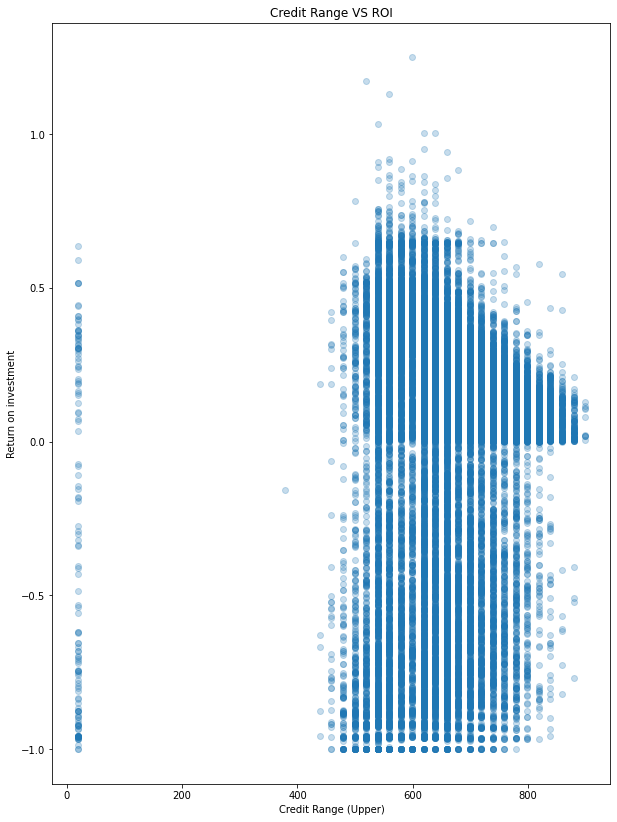

In [12]:
# a scatterplot comparing the CSRU and ROI variables
plt.figure(figsize = [10, 14])
plt.scatter(data = loans_to_2008, x = 'CreditScoreRangeUpper', y = 'ROI', alpha=1/4)
plt.xlabel('Credit Range (Upper)')
plt.ylabel('Return on investment')
plt.title('Credit Range VS ROI')
plt.show();

> What does the above picture tell us?

> There is a wall of negative ROIs from about CSRU 450 to CSRU 800. And a roof of positive ROIs that climbs jerkily up to a peak of about CSRU 600 / ROI .75, and then slopes gradually down until about CSRU 900 / ROI .1 -- overhanging the negative-ROI wall.

> From this graph, it looks like during this time period, CSRU 550-650 was was the credit range with the highest payoffs. Probably related to the relatively high interest rates charged to people with those (not spectacularly good) credit ratings. 

> (I don't know why there don't seem to be any loans for CSRU scores below 400, excepting that line of loans to people with CSRUs of about zero -- which I also can't explain.)


## CreditScoreRangeUpper versus ROI (Barplot)

> The above scatterplot with alpha-shading gives a sense of the distribution of ROIs at the various credit ranges, but it doesn't clearly demonstrate the average ROIs for loans from each credit range. We'll draw a barplot for that.

Text(0.5, 1.0, 'Credit Range VS ROI')

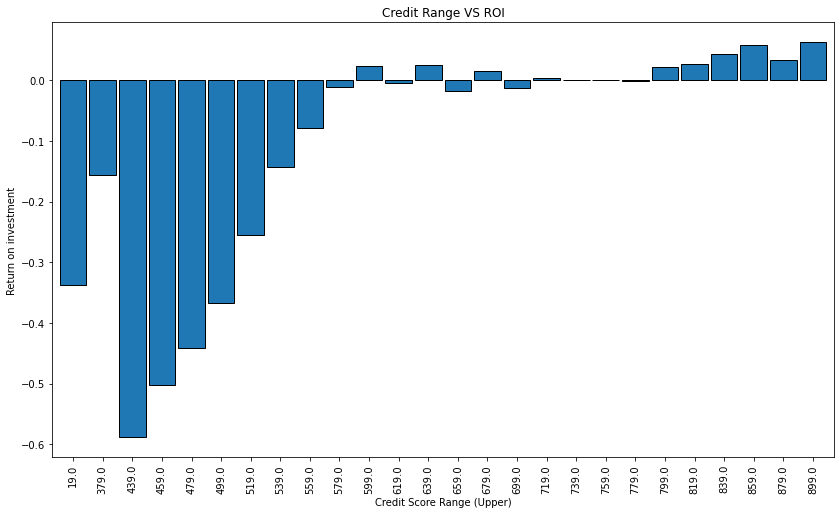

In [13]:
loans_to_2008[['CreditScoreRangeUpper', 'ROI']].groupby('CreditScoreRangeUpper').ROI.mean().plot.bar(edgecolor='black', figsize=[14,8], width=.9);
plt.xlabel('Credit Score Range (Upper)')
plt.ylabel('Return on investment')
plt.title('Credit Range VS ROI')

> The middle Credit Ranges show mixed results. The lower Credit Score Ranges resulted in uniformly negative average ROIs. Only up around upper credit ranges of about CSRU 800-900 does Prosper start to turn a solid profit. 

> There is a gradual downward trend in the negative range from about CSRU 599 / ROI -.1 through CSRU 439 / ROI -.58 

> There is an upward trend from about CSRU 800 / ROI .05 through about CSRU 900 / ROI .4 (with a dip down at CSRU 879 / ROI .2)

> In hindsight, During this time period, loaning only to people with CSRUs over 719 would've been a very safe bet; and loaning only to people with CSRUs below 579 would've been a terrible bet, resulting in huge losses.

## Correlation Coefficient scores for the full loans_to_2008 data set.

| Variables | Result | Type of Test |
| :- | -: | :-: |
| ROI / Credit Grade | .138815 | spearman
| ROI / Credit Score Range | .121623 | pearson
| NLS / Credit Grade | .201647 | spearman
| NLS / Credit Score Range | .265645 | spearman
| NLS / Amount Delinquent | - .150028 | spearman
| ROI / NLS | .722029 | spearman
| ROI / Stated Monthly Income | .022 & .003 | pear & spear
| ROI / DebtToIncomeRatio | -.022 & -.028 | pear & spear
| ROI / AmountDelinquent | -.042 & -.042 | pear & spear
| Stated Monthly Income / Credit Score Range | .240603 | spearman
| Stated Monthly Income / Credit Score Range | .198644 | pearson
| Credit Grade / Credit Score Range | .98771 | spearman

NLS = NewLoanStatus = Successful/Unsuccessful based on whether or not the loan was completed.

ROI = Return on Investment 

ROI calculation: loans_to_2008['ROI'] = (loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount']

Whenever Credit Grade was one of the variables, the results here have been multiplied by -1 (because I created the CreditGradeNumeric variable backwards)

> #### typical_incomes dataframe:

> When I threw out incomes outside of the main shape of the StatedMonthlyIncome versus ROI graph, the scores improved a little: ROI/CSRU .14 (p) | SMI/CSRU .26 (p) & .27 (s)

> The best predictor-variable/success-metric scores were with NewLoanStatus (the simple: Successful/Not Successful metric): 

> NLS/CSRU .27, NLS/CG .20, and NLS/AD -.15

> With ROI, the best predictor/metric scores were ROI/CG .14 and ROI/CSRU .12

> All other prector/metric scores were below |.1| 

> Generally, weak correlations are considered to start around |.1|; scores below |.1| indicated correlations that are either very weak or nonexistent.

> It was encouraging to see the strong correlation between my two success-metrics: ROI/NLS .72 (If the metrics were to have a chance at being credible, they should've been highly correlated -- and they were.)

> I was surprised that SMI and CSRU weren't more closely related: SMI/CSRU .24 spearman and .20 pearson (a fairly weak correlation -- moderate correlations begin at about .3). I guess one's monthly income is not an overwhelmingly important factor in determining one's credit rating.

> As I assumed the Credit Grades are probably just a less exact version of the Credit Score Ratings, I thought CG/CSRU would result in a high very high correlation score, but .99 is a very very very high score. 

### Correlation Scores after splitting the typical_loans dataframe into Successful & Unsuccessful Loans:

#### Successful Loans (within income range \\$300-\\$60K)

| Variables | Pearson Score | Spearman Score |
| :- | -: | :-: |
| ROI/SMI | -.14 | -.12 | 
| ROI/CSRU | -.56 | -.57 |
| ROI/DTIR | .08 | .26 |
| ROI/AD | .11 | .27 |
| SMI/CSRU | .25 | .26 |

#### Unsuccessful Loans (=(within income range \\$300-\\$60K):

| Variables | Pearson Score | Spearman Score |
| :- | -: | :-: |
| ROI/SMI | .03 | .07 | 
| ROI/CSRU | .07 | .1 |
| SMI/CSRU | .25 | .34 |

#### Discussion of the Successful Loan correlation scores:

> Note that with all these contortions (throwing out the income ranges that lay outside the main shape of the graph and then breaking the data into Successful and Unsuccessful dataframes, ROI/SMI finally breaks |.1|, but it is now a negative instead of a positive score: -.14 Pearson and -.12 Spearman. 

> And ROI/CSRU goes from a weak correlation to a strong one, but the score has also flipped from positive to negative: -.56 Pearson and -.57 Spearman.

> What causes the signs to flip? I discuss this beneath the bottom graph.

### SMI versus ROI, with color-coded CSRU - broken into Successful & Unsuccesful Loan subsets


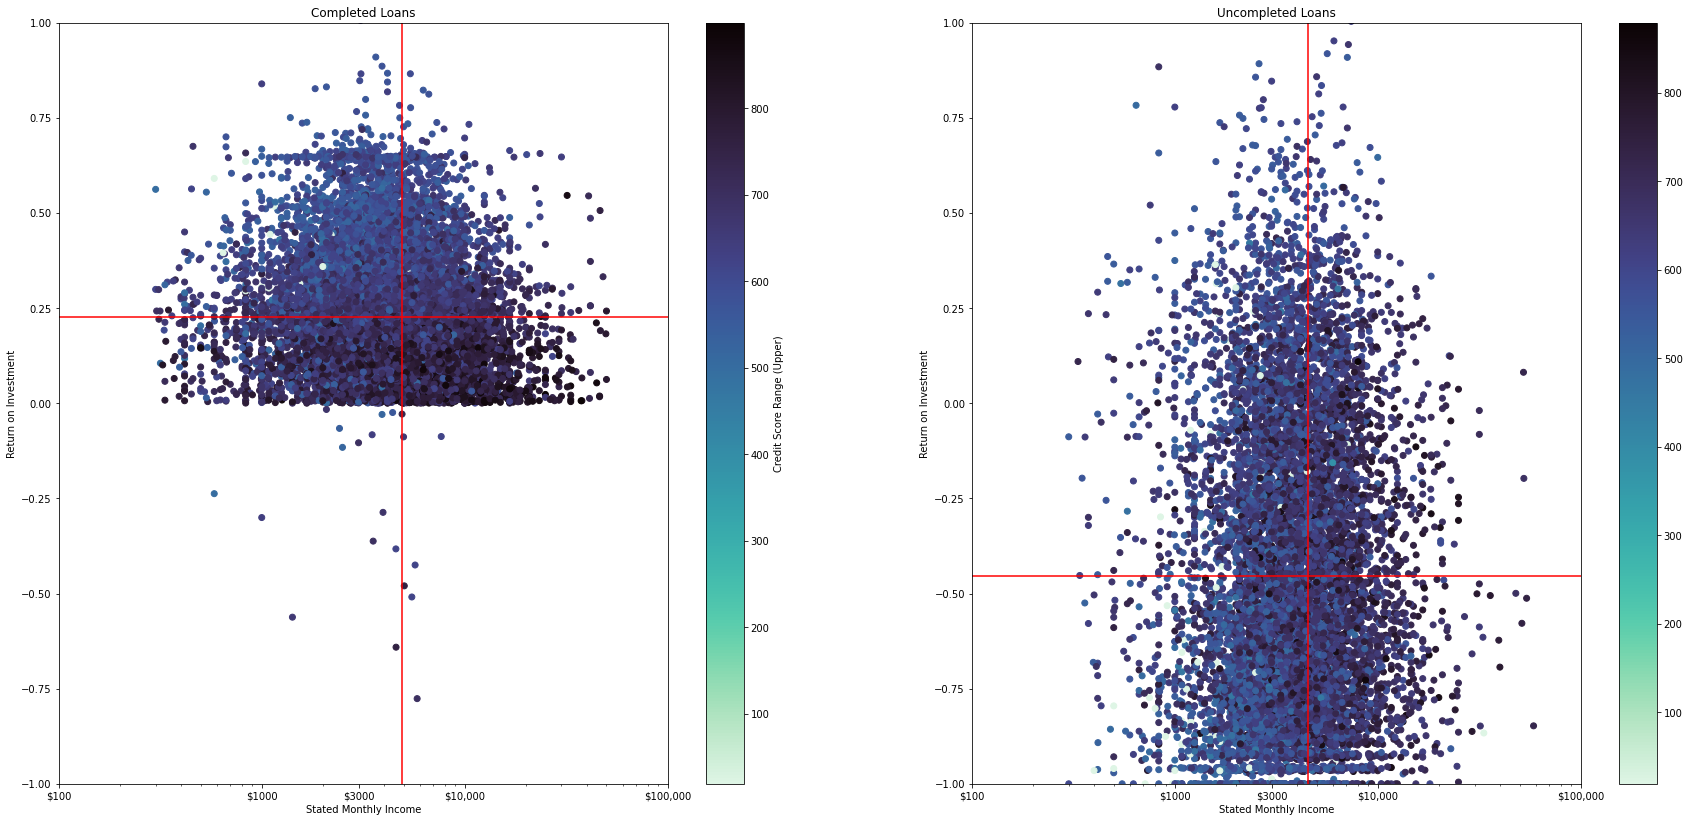

In [14]:
#  TWO PLOTS IN ONE FIGURE
plt.figure(figsize = [30, 14])
base_color = sb.color_palette()[0]
plt.title('ROI versus CSRU - Red Lines represent mean values of each variable')

# LEFT plot: SMI/CSRU/ROI - Successful loans
plt.subplot(1, 2, 1)
plt.scatter(data = typ_succ, x = 'StatedMonthlyIncome', y = 'ROI', c = 'CreditScoreRangeUpper',
            cmap = 'mako_r')

plt.xscale('log')
plt.xticks([.10, 1, 10, 100, 1000, 3000, 10000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$3000','$10,000', '$100,000'])
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title("Completed Loans")
plt.colorbar(label='Credit Score Range (Upper)')
plt.axvline(x=avg_smi_succ, color='r')
plt.axhline(y=avg_roi_succ, color='r')
plt.xlim(100, 100000)
plt.ylim(-1,1);

# RIGHT plot: Unsuccessful loans
plt.subplot(1, 2, 2)
plt.scatter(data = typ_unsucc, x = 'StatedMonthlyIncome', y = 'ROI', c = 'CreditScoreRangeUpper',
            cmap = 'mako_r')
plt.colorbar()
plt.xscale('log')
plt.xticks([.10, 1, 10, 100, 1000, 3000, 10000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$3000', '$10,000', '$100,000'])
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.title("Uncompleted Loans")
plt.axvline(x=avg_smi_unsu, color='r')
plt.axhline(y=avg_roi_unsu, color='r')
plt.xlim(100, 100000)
plt.ylim(-1,1)
plt.show();

> If the top left and bottom right quadrants have the most observations, there is a negative linear trend. That's what seems to be happening in the Successful graph. 

> If the bottom left and top right quadrants have the most observations, there is a positive linear trend.

> The Unsuccessful graph seems to be evenly distributed between the bottom-right/upper-left and upper-right/bottom-left diagonals. That would indicate correlations close to zero.

> The above splitting of the data into Successful and Unsuccessful makes the Successful section pretty much only ROIs with a positive outcome. It is not surprising that those ROIs should correlate negatively with a person's income and credit rating. Lower credit ratings result in higher interest rates. And lower incomes correlate with lower credit scores. (So it seems likely that when a borrower with a lower credit score pays off their loan, the lender nets a higher profit than when a borrower with a higher credit score pays off their loan.) 

> Comparing the above graph to one drawn from the same data, but without splitting the data into Successful and Unsuccessful loans, will show graphically why SMI/ROI score flipped from a positive one to a negative one after we split the data into the Succesful and Unsuccessful subsets.

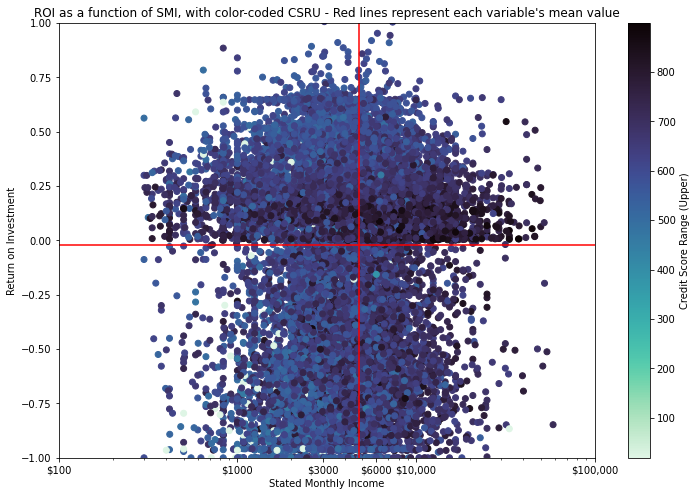

In [15]:
# find the values for the lines drawn through the mean of each variable's values
avg_smi = typical_incomes.StatedMonthlyIncome.mean()
avg_roi = typical_incomes.ROI.mean()

# a single plot
base_color = sb.color_palette()[0]
plt.figure(figsize = [12, 8])
plt.scatter(data = typical_incomes, x = 'StatedMonthlyIncome', y = 'ROI', c = 'CreditScoreRangeUpper',
            cmap = 'mako_r')

plt.xscale('log')
plt.xticks([.10, 1, 10, 100, 1000, 3000, 6000, 10000, 100000], ['$0.10', '$1', '$10', '$100', '$1000', '$3000','$6000','$10,000', '$100,000'])
plt.xlabel('Stated Monthly Income')
plt.ylabel('Return on Investment')
plt.colorbar(label='Credit Score Range (Upper)')
plt.title("ROI as a function of SMI, with color-coded CSRU - Red lines represent each variable's mean value")
plt.axvline(x=avg_smi, color='r')
plt.axhline(y=avg_roi, color='r')
plt.xlim(100, 100000)
plt.ylim(-1,1);

> The bulk of the x-points are on the left side of the average value. This makes sense: the values on the left side each have smaller individual values, so it will take more of them to make up their portion of half the overall value.

> When the whole dataset is plotted, the large number of points in the bottom left quadrant balances out the large number in the top left quadrant. The result is a very slight positive correlation (the top half is wider, but the bottom half is quite wide on the left side and about 25% taller than the left side). 

> But when (in the Successful case) we keep only the mushroom top, the red y-line moves up only from ROI almost-0 to ROI-.25 (because the bottom of the mushroom-top is much wider than the top of the mushroom-top), while the red x-line remains the same. And so we get a negative correlation (more points on the NW-SE diagonal than on the SW-NE diagonal).

### Conclusions

> We didn't discover any great predictors for our loan-success metrics. Perhaps the peculiar circumstances surrounding this particular dataset (loans_to_2008) is to blame. Perhaps not. 

> The high correlation scores between the two loan-success metrics was more encouraging, as was the fact that the relationships that one would've thought should be positive were positive, and the scores that one would've thought should be negative (ie: ROI/DebtToIncomeRatio & ROI/AmountDelinquent) were negative. These findings make me feel that the analysis was at least on the right track.

In [ ]:
!jupyter nbconvert prosper_slide_deck.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook prosper_slide_deck.ipynb to slides
[NbConvertApp] Writing 1849717 bytes to prosper_slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/prosper_slide_deck.slides.html
Use Control-C to stop this server
